In [1099]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from numpy.linalg import inv
from scipy.stats import norm
import pymc as pm
import arviz as az

Tratamos el dataset como una serie de estudios individuales e independientes sobre las tendencias prosociales de los chimpances 

In [1100]:
#IMPORTO EL DATASET
file_path = os.path.join(os.getcwd(), "chimpanzees.csv")
data = pd.read_csv(file_path, sep = ";")

In [1101]:
print(data.columns)
print(data.shape)

Index(['actor', 'recipient', 'condition', 'block', 'trial', 'prosoc_left',
       'chose_prosoc', 'pulled_left'],
      dtype='object')
(504, 8)


Exploro la veriable target

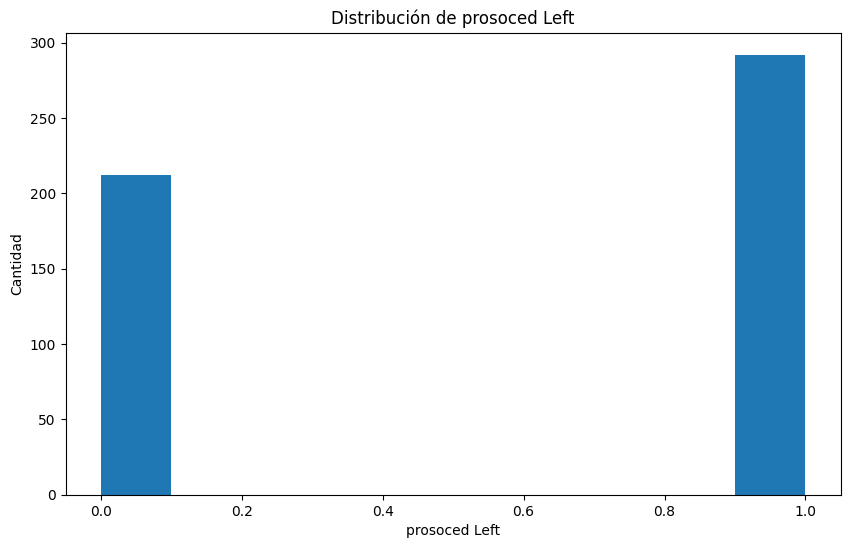

En la muestra se tiro la palanca izquierda 292 (58%) veces
En la muestra se tiro la palanca derecha 212 (42%) veces


In [1102]:
data_target = data['pulled_left']

plt.figure(figsize=(10, 6))
plt.hist(data_target)
plt.xlabel('prosoced Left')
plt.ylabel('Cantidad')
plt.title('Distribución de prosoced Left')
plt.show()

cant_left = sum(data_target)
cant_right = len(data_target) - cant_left

print(f"En la muestra se tiro la palanca izquierda {cant_left} ({round(round(cant_left / len(data_target),2) * 100)}%) veces")
print(f"En la muestra se tiro la palanca derecha {cant_right} ({round(round(cant_right / len(data_target),2) * 100)}%) veces")

Exploramos las variables predictoras, $prosc$ _ $left$  y $condition$

Hubo 252 experimentos con compañero
Hubo 252 experimentos sin compañero


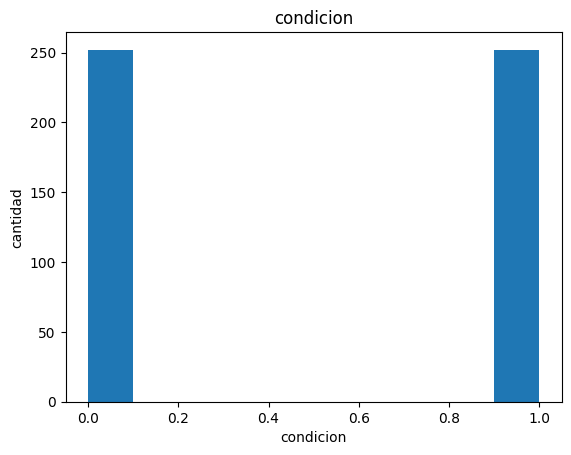

In [1103]:
#EXPLORAMOS LA CONDICION
data_condition = data["condition"]

plt.hist(data_condition)
plt.title("condicion")
plt.xlabel("condicion")
plt.ylabel("cantidad")

compañero = sum(data_condition)
sin_compañero = 504 - compañero

print(f"Hubo {compañero} experimentos con compañero")
print(f"Hubo {sin_compañero} experimentos sin compañero")

Hubo 252 experimentos con la opcion prosocial a la izquierda
Hubo 252 experimentos con la opcion prosocial a la derecha


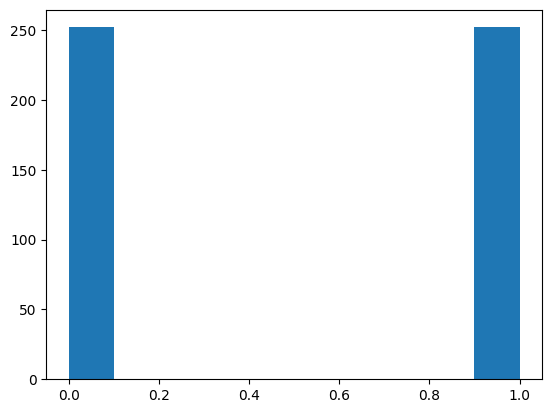

In [1104]:
#EXPLORAMOS PROSOC_LEFT
data_prosoc_left = data['prosoc_left']
plt.hist(data_prosoc_left)

cant_left = sum(data_prosoc_left)
cant_no_left = len(data_prosoc_left) - cant_left

print(f"Hubo {cant_left} experimentos con la opcion prosocial a la izquierda")
print(f"Hubo {cant_no_left} experimentos con la opcion prosocial a la derecha")

Ahora, exploramos un poco el resto de las variables para dar una idea de general del dataset

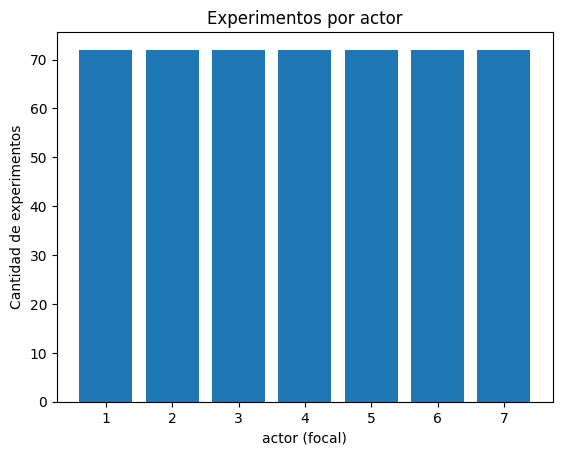

In [1105]:
#EXPLORAMOS LA VARIABLE DEL "FOCAL"
data_actor = data["actor"]

actor_counts = {}
for actor in data_actor:
    if actor in actor_counts:
        actor_counts[actor] += 1
    else:
        actor_counts[actor] = 1

plt.bar(actor_counts.keys(), actor_counts.values())
plt.xlabel('actor (focal)')
plt.ylabel('Cantidad de experimentos')
plt.title('Experimentos por actor')
plt.show()

# print(actor_counts)

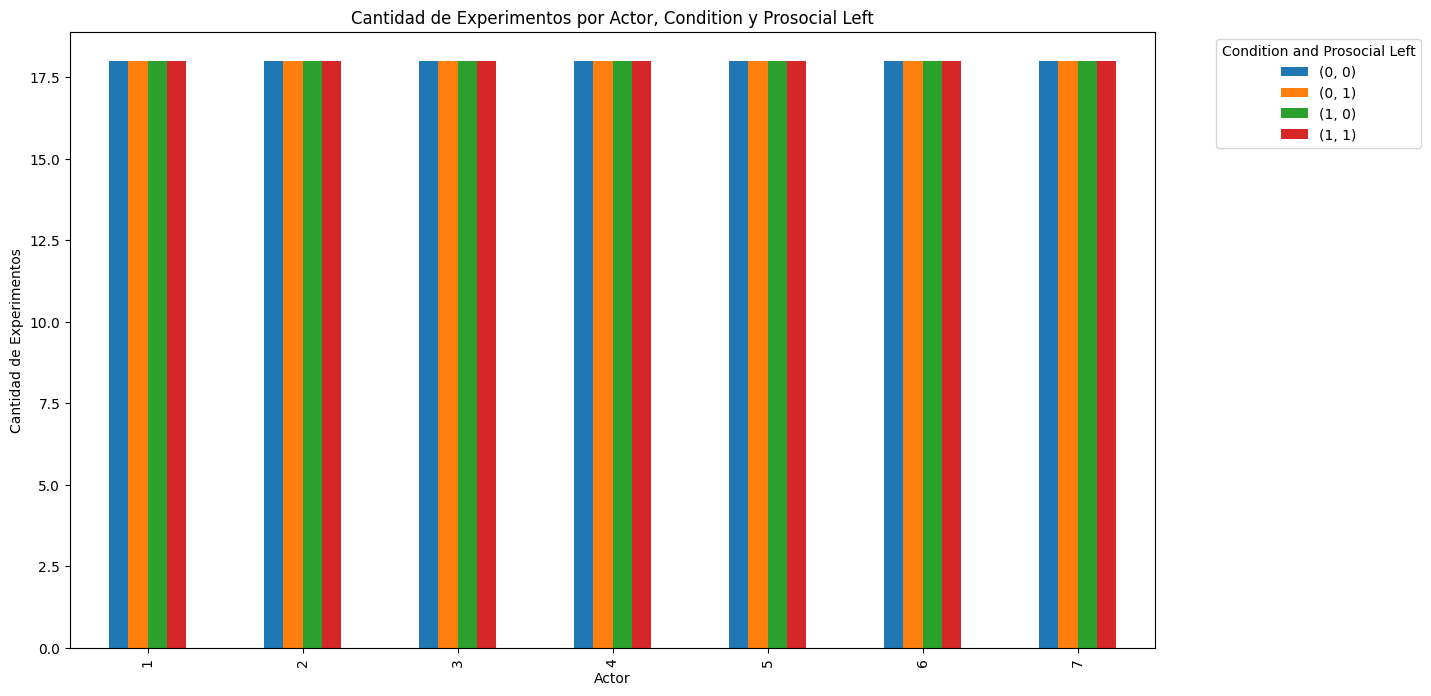

In [1106]:
#Valido el metodo cientifico 
grouped_data = data.groupby(['actor', 'condition', 'prosoc_left']).size().reset_index(name='experiment_count')

pivot_data = grouped_data.pivot_table(index='actor', columns=['condition', 'prosoc_left'], values='experiment_count', fill_value=0)

pivot_data.plot(kind='bar', figsize=(14, 8))
plt.xlabel('Actor')
plt.ylabel('Cantidad de Experimentos')
plt.title('Cantidad de Experimentos por Actor, Condition y Prosocial Left')
plt.legend(title='Condition and Prosocial Left', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

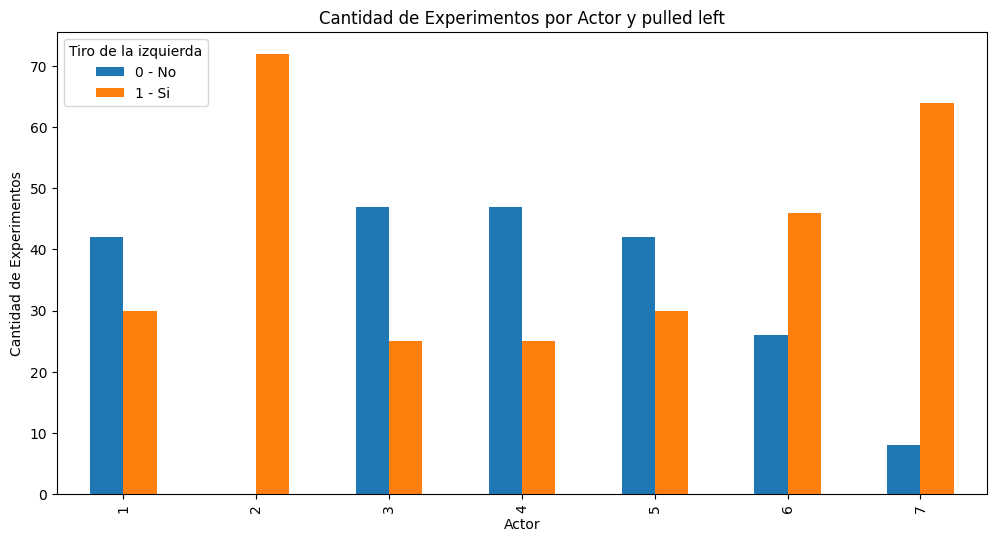

In [1107]:
grouped_data = data.groupby(['actor', 'pulled_left']).size().reset_index(name='experiment_count')

pivot_data = grouped_data.pivot(index='actor', columns='pulled_left', values='experiment_count').fillna(0)

pivot_data.plot(kind='bar', figsize=(12, 6))
plt.xlabel('Actor')
plt.ylabel('Cantidad de Experimentos')
plt.title('Cantidad de Experimentos por Actor y pulled left')
plt.legend(title='Tiro de la izquierda', labels=['0 - No', '1 - Si'])
plt.show()

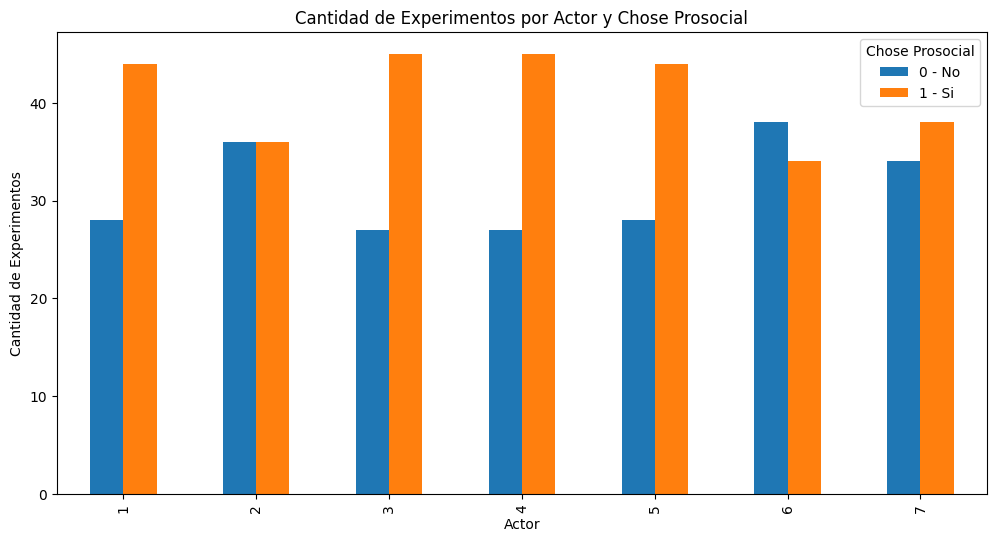

In [1108]:
grouped_data = data.groupby(['actor', 'chose_prosoc']).size().reset_index(name='experiment_count')

pivot_data = grouped_data.pivot(index='actor', columns='chose_prosoc', values='experiment_count').fillna(0)

pivot_data.plot(kind='bar', figsize=(12, 6))
plt.xlabel('Actor')
plt.ylabel('Cantidad de Experimentos')
plt.title('Cantidad de Experimentos por Actor y Chose Prosocial')
plt.legend(title='Chose Prosocial', labels=['0 - No', '1 - Si'])
plt.show()

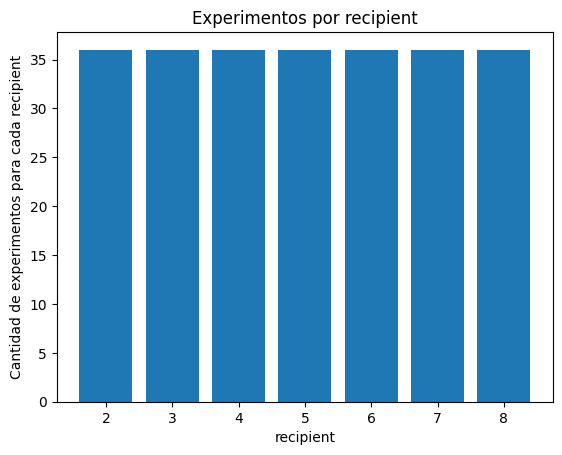

Cantidad de experimentos sin recipient: 252


In [1109]:
#EXPLORAMOS RECIPIENT
data_recipient = data["recipient"]

recipient_counts = {}
nan_count = 0
for rec in data_recipient:
    if pd.isna(rec):
        nan_count += 1
    else:
        if rec in recipient_counts:
            recipient_counts[rec] += 1
        else:
            recipient_counts[rec] = 1

plt.bar(recipient_counts.keys(), recipient_counts.values())
plt.xlabel('recipient')
plt.ylabel('Cantidad de experimentos para cada recipient')
plt.title('Experimentos por recipient')
plt.show()

# print(recipient_counts)
print(f"Cantidad de experimentos sin recipient: {nan_count}")

Hasta aca podemos validar que hubo 504 experimentos, donde cada uno de los 7 chimpances hizo 72 experimentos, la mitad (36) con un recipient y la mitad sin, como indica la descripcion del dataset.

Text(0.5, 1.0, 'Distribucion de actores y recipients')

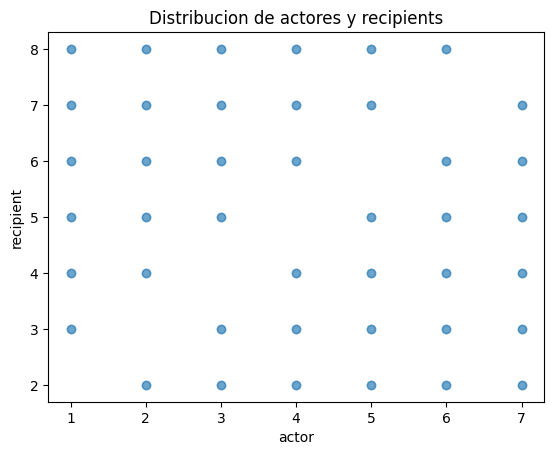

In [1110]:
plt.scatter(data["actor"], data["recipient"], alpha = 0.16)
plt.xlabel("actor")
plt.ylabel("recipient")
plt.title("Distribucion de actores y recipients")

podemos interpretar que cada actor tiene la misma cantidad de experimentos con cada recipient (6 de los 36), y al no existir la diagonal central, que cada actor tambien fue recipient. De cualquier manera no tiene relacion con lo que se intenta modelar

286
218


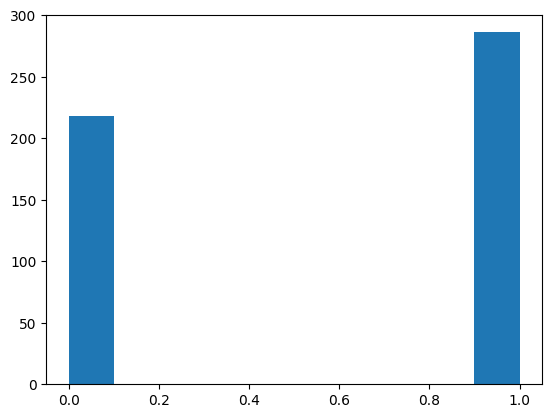

In [1111]:
#EXPLORAMOS CHOSE PROSOC
data_prosoc = data['chose_prosoc']
plt.hist(data_prosoc)

cant_prosoc = sum(data_prosoc)
cant_no_prosoc = len(data_prosoc) - cant_prosoc

print(cant_prosoc)
print(cant_no_prosoc)

esta variable se relaciona directamnete con:

         -si la opcion prosocial estaba a la izquieda 
         
         -si tiro de la izquierda 

no aporta mas valor que la de la combinacion de ambas (aunque una de ellas es el target, esta es la combinacion de ambas)

$MODELO$ $FRECUENTISTA$

Lo que se busca determinar es la probabilidad de que se tire la palanca izquierda en cada escenario. Otra manera de interpretar esta probabilidad de una manera practica, seria si va a tirar de la palanca izquierda o no. La prediccion de la probabilidad es un valor entre 0 y 1, y esta interpretacion negativo - positivo tiene 2 resultados posibles, 0 o 1.

Por esta razon no se puede usar modelos discretos o continuos, ya sean poisson, gamma, normal, etc. La necesidad de un valor entre 0 y 1 indica que necesitamos usar un modelo binario.

Planteamos un modelo 
$$Y \sim Binom(\mu) $$
$$ \eta = \log(\frac{\mu}{1-\mu}) = \beta_0 + \beta_1X1 + \beta_2X2 $$



Como la binomial es una distribución de la familia exponencial, sabemos que:

$$\theta = \log(\frac{\mu}{1-\mu})$$

$$\kappa(\theta) = -\log(1- \mu) = \log(1+e^\theta)$$

$$\phi = 1/n$$


para encontrar los parametros de la regresion lineal (los beta) y poder obtener los valores de Y, usamos un GLM binomial con su link canonico (la funcion logit) 

$$ \mu = \mu(\beta_0,\beta_1, \beta_2) = \frac{e^{\beta_0 + \beta_1x1_i + \beta_2x2_i}}{1+e^{\beta_0 + \beta_1x1_i + \beta_2x2_i}} $$ 

Dada la likelihood de la funcion binomial, si quiero maximizarla, es lo mismo que maximizar su $\log(\mathcal{L}(\mu)) $, y es a su vez lo mismo que minimizar la  $-\log(\mathcal{L}(\mu)) $ 

$DISCLAIMER$:

Trabajo bajo el supuesto de que todos los experimentos son independientes entre si. 

In [1112]:
X1 = data['prosoc_left']
X2 = data['condition']

Y = data['pulled_left']

In [1113]:
intercept = np.ones(X1.shape)
X = np.column_stack((intercept,X1, X2))

def neg_log_likelihood_binom(beta, X, Y):
    eta = np.dot(X, beta)
    mu = np.exp(eta) / (1 + np.exp(eta))
    return -np.sum(Y * np.log(mu) + (1 - Y) * np.log(1 - mu))

initial_beta = np.zeros(X.shape[1])
res_binom = minimize(neg_log_likelihood_binom, initial_beta, args=(X, Y))
b0, b1, b2 = res_binom.x  #estimacion 
print(f"Los valores de los betas son: {res_binom.x}")

def predict_proba(X, beta):
    return np.exp(np.dot(X, beta)) / (1 + np.exp(np.dot(X, beta)))

def predict_cero_uno(X, beta):
    proba = np.exp(np.dot(X, beta)) / (1 + np.exp(np.dot(X, beta)))
    if proba >= 0.5 :
        return 1
    else:
        return 0

##PARA MOSTRAR LAS PREDICCIONES, SIMPLEMNETE TENGO QUE DESPLEGAR LAS 4 CASUISTICAS POSIBLES
X_NEW = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
intercept_new = np.ones(X_NEW.shape[0])  
X_new = np.column_stack((intercept_new, X_NEW))  

Y_prob_pred = predict_proba(X_new, res_binom.x)
print(f"las probabilidades predichas son: {Y_prob_pred}")
Y_0o1 = [predict_cero_uno(x, res_binom.x) for x in X_new] #PASO LA PROBA A 0 O 1


Los valores de los betas son: [ 0.14739788  0.5588264  -0.19930299]
las probabilidades predichas son: [0.5367829  0.48702664 0.66956633 0.62408448]


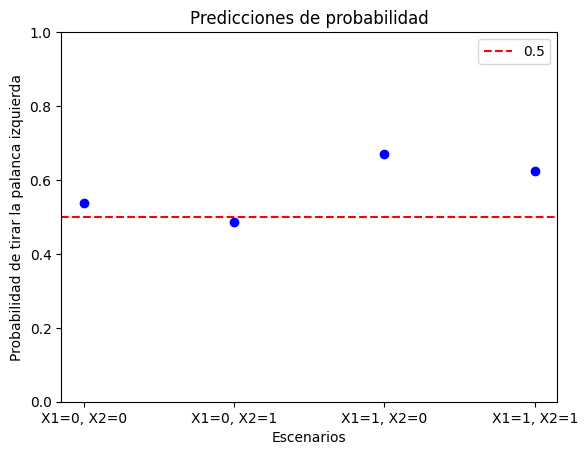

In [1114]:
casuisticas = ['X1=0, X2=0', 'X1=0, X2=1', 'X1=1, X2=0', 'X1=1, X2=1']
plt.scatter(casuisticas, Y_prob_pred, color='blue')
plt.axhline(y=0.5, color='red', linestyle='--', label='0.5')  
plt.xlabel("Escenarios")
plt.ylabel("Probabilidad de tirar la palanca izquierda")
plt.title("Predicciones de probabilidad")
plt.ylim(0, 1)
plt.legend()  
plt.show()

Buscamos el sesgo de los estimadores para tener un intervalo de confianza. Para eso usamos la matriz de fisher.


In [1115]:
n = len(Y)
mu = np.exp(X @ res_binom.x) / (1 + np.exp(X @ res_binom.x))
W = np.diag(mu * (1 - mu))
I = n * X.T @ W @ X
cov_matrix = inv(I)

se_b0 = np.sqrt(cov_matrix[0,0])
se_b1 = np.sqrt(cov_matrix[1,1])
se_b2 = np.sqrt(cov_matrix[2,2])

print(f"IC 95% para b0: ({round(b0 - se_b0 * 1.96, 3)}, {round(b0 + se_b0 * 1.96, 3)})")
print(f"IC 95% para b1: ({round(b1 - se_b1 * 1.96, 3)}, {round(b1 + se_b1 * 1.96, 3)})")
print(f"IC 95% para b2: ({round(b2 - se_b2 * 1.96, 3)}, {round(b2 + se_b2 * 1.96, 3)})")


IC 95% para b0: (0.134, 0.161)
IC 95% para b1: (0.543, 0.575)
IC 95% para b2: (-0.215, -0.183)


In [1116]:
for cond, prosoc in X_NEW:
    min_eta = round(b0 - se_b0 * 1.96, 3) + round(b1 - se_b1 * 1.96, 3) * cond + round(b2 - se_b2 * 1.96, 3) * prosoc
    max_eta = round(b0 + se_b0 * 1.96, 3) + round(b1 + se_b1 * 1.96, 3) * cond + round(b2 + se_b2 * 1.96, 3) * prosoc

    min_mu = np.exp(min_eta)/(1+np.exp(min_eta))
    max_mu = np.exp(max_eta)/(1+np.exp(max_eta))

    print(f"X1={cond}, X2={prosoc} : IC 95% para probabilidad de pulled_left = [{round(min_mu,3)},{round(max_mu,3)}]")

X1=0, X2=0 : IC 95% para probabilidad de pulled_left = [0.533,0.54]
X1=0, X2=1 : IC 95% para probabilidad de pulled_left = [0.48,0.495]
X1=1, X2=0 : IC 95% para probabilidad de pulled_left = [0.663,0.676]
X1=1, X2=1 : IC 95% para probabilidad de pulled_left = [0.613,0.635]


Por otro lado, si el objetivo fuera determinar la probabilidad de elegir la opcion prosocial, en lugar de determinar la probabilidad de tirar de la palanca izquierda, podemos usar el mismo modelo, ya que sigue siendo un valor entre cero y uno. Lo que hacemos es usar la columna chose_prosocial como target.

[-0.0974486   0.65313548  0.099582  ]
[0.47565711 0.50053335 0.63545398 0.65819681]


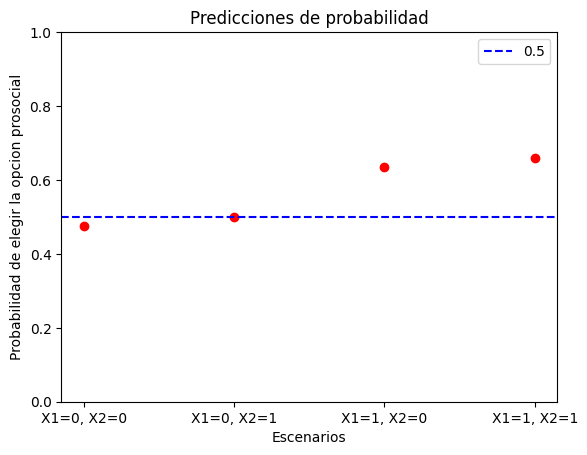

In [1117]:
X1 = data['prosoc_left']
X2 = data['condition']

Y = data['chose_prosoc']

intercept = np.ones(X1.shape)
X = np.column_stack((intercept,X1, X2))

def neg_log_likelihood_binom(beta, X, Y):
    eta = np.dot(X, beta)
    mu = np.exp(eta) / (1 + np.exp(eta))
    return -np.sum(Y * np.log(mu) + (1 - Y) * np.log(1 - mu))

initial_beta = np.zeros(X.shape[1])
res_binom = minimize(neg_log_likelihood_binom, initial_beta, args=(X, Y))
b0, b1, b2 = res_binom.x   
print(res_binom.x)

## VEMOS LA PROBABILIDAD PARA CADA CASUISTICA
X_NEW = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
intercept_new = np.ones(X_NEW.shape[0])  
X_new = np.column_stack((intercept_new, X_NEW))  

Y_prob_pred = predict_proba(X_new, res_binom.x)
print(Y_prob_pred)
Y_0o1 = [predict_cero_uno(x, res_binom.x) for x in X_new] 

casuisticas = ['X1=0, X2=0', 'X1=0, X2=1', 'X1=1, X2=0', 'X1=1, X2=1']
plt.scatter(casuisticas, Y_prob_pred, color='red')
plt.axhline(y=0.5, color='blue', linestyle='--', label='0.5')  
plt.xlabel("Escenarios")
plt.ylabel("Probabilidad de elegir la opcion prosocial")
plt.title("Predicciones de probabilidad")
plt.ylim(0, 1)
plt.legend()  
plt.show()

In [1118]:
n = len(Y)
mu = np.exp(X @ res_binom.x) / (1 + np.exp(X @ res_binom.x))
W = np.diag(mu * (1 - mu))
I = n * X.T @ W @ X
cov_matrix = inv(I)

se_b0 = np.sqrt(cov_matrix[0,0])
se_b1 = np.sqrt(cov_matrix[1,1])
se_b2 = np.sqrt(cov_matrix[2,2])

print(f"IC 95% para b0: ({round(b0 - se_b0 * 1.96, 3)}, {round(b0 + se_b0 * 1.96, 3)})")
print(f"IC 95% para b1: ({round(b1 - se_b1 * 1.96, 3)}, {round(b1 + se_b1 * 1.96, 3)})")
print(f"IC 95% para b2: ({round(b2 - se_b2 * 1.96, 3)}, {round(b2 + se_b2 * 1.96, 3)})")
print("")

for cond, prosoc in X_NEW:
    min_eta = round(b0 - se_b0 * 1.96, 3) + round(b1 - se_b1 * 1.96, 3) * cond + round(b2 - se_b2 * 1.96, 3) * prosoc
    max_eta = round(b0 + se_b0 * 1.96, 3) + round(b1 + se_b1 * 1.96, 3) * cond + round(b2 + se_b2 * 1.96, 3) * prosoc

    min_mu = np.exp(min_eta)/(1+np.exp(min_eta))
    max_mu = np.exp(max_eta)/(1+np.exp(max_eta))

    print(f"X1={cond}, X2={prosoc} : IC 95% para probabilidad de pulled_left = [{round(min_mu,3)},{round(max_mu,3)}]")


IC 95% para b0: (-0.111, -0.084)
IC 95% para b1: (0.637, 0.669)
IC 95% para b2: (0.084, 0.115)

X1=0, X2=0 : IC 95% para probabilidad de pulled_left = [0.472,0.479]
X1=0, X2=1 : IC 95% para probabilidad de pulled_left = [0.493,0.508]
X1=1, X2=0 : IC 95% para probabilidad de pulled_left = [0.629,0.642]
X1=1, X2=1 : IC 95% para probabilidad de pulled_left = [0.648,0.668]


En este caso, para una casuistica (X1=0, X2=1), no se puede estar seguro con un 95% del tipo de eleccion que se hara en ese caso, esto se debe a que el intervalo de confianza contiene al 0.5

$TEST$ $DE$ $HIPOTESIS$

Basandome en los resultados del modelo anterior, donde en tres de las cuatro casuisticas puedo asumir que el chimpance va a tirar de la palanca izquierda, quiero plantear un test de hipotesis para poder determinar si puedo, con un 95% de confianza (alfa = 0.05), decir que en genral un chimpanze tiene preferencia por algun lado en particular


$H_0$: $p = 0.5$  
$H_a$: $p  <> 0.5$

In [1119]:
Y = data['pulled_left']

alpha = 0.05
# alpha = 0.0003

En primer lugar construyo la region de rechazo, que es donde 

$$|Z| \geq \frac{z_{\alpha}}{2}$$

el punto critico es en este caso:

In [1120]:
pto_critico = norm.ppf(1 - alpha / 2)

y el estadistico de prueba es 
$$
Z = \frac{\hat{p} - p_0}{\sqrt{\frac{p_0 (1 - p_0)}{n}}}
$$

In [1121]:
p_hat = sum(Y) / len(Y)
p0 = 0.5
n = len(Y)

Z = (p_hat - p0) / np.sqrt(p0 * (1 - p0) / n)

if Z >= pto_critico:
    print(f"Rechazo H0, {round(Z, 3)} >= {round(pto_critico,2)}")
else:
    print(f"No rechazo H0 {round(Z, 3)} < {round(pto_critico,2)}")

Rechazo H0, 3.563 >= 1.96


Busco el p - valor, o sea, el nivel de significancia con el que empiezo a rechazar H0 basado en la data observada

In [1122]:
p_valor = 2 * (1 - norm.cdf(abs(Z)))
print(f"El p-valor es {round(p_valor, 4)}")

El p-valor es 0.0004


$MODELO$ $BAYESIANO$

En primer lugar probe planteando un modelo binomial donde p (proporcion de exitos) se modela con una distribucion binomial y se usa un prior uniforme no informativo. 


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-package
s\Python311\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


    mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
p  0.579  0.022   0.538     0.62      0.001      0.0    1755.0    3065.0   

   r_hat  
p    1.0  


<Figure size 800x500 with 0 Axes>

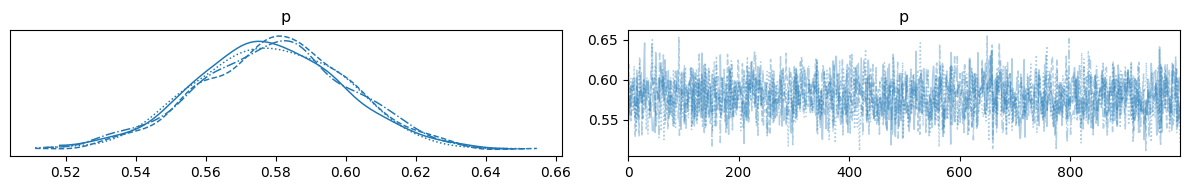

[0.53548719 0.62108109]


In [1123]:
X1 = data['prosoc_left']
X2 = data['condition']

Y = data['pulled_left']

with pm.Model() as binomial_model:
    p = pm.Uniform('p', 0, 1)
    y = pm.Binomial('y', n = len(Y), p = p, observed = sum(Y))
    trace = pm.sample(1000, tune = 1000)

print(pm.summary(trace))

#grafico la posterior
plt.figure(figsize=(8, 5))
pm.plot_trace(trace)
plt.tight_layout()
plt.show()

ps = trace.posterior.p.values.flatten()
hdis = az.hdi(ps , hdi_prob = .95)
print(hdis)

Este modelo no me permite ver lo que estoy buscando, ya que esto modela la  proporcion de exitos del total de experimentos, no la probabilidad de cierto resultado en un experimento aislado. Ademas, asume una probabilidad p para todo el conjunto de datos y no permite involucrar variables predictoras

Podria plantear un modelo donde la probabilidad se modela con una bernoulli en lugar de una binomial. Esto permite modelar un experimento individual en lugar de un conjunto. Ademas, propongo una beta como prior de p, en lugar de una uniforme. Esto se debe a que una fuincion beta es el prior conjugado de la likelihood de bernoulli, y me permite saber que forma tendra la posterior. Uso tambien una beta no informativa, donde p es 0.5

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-package
s\Python311\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.


    mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
p  0.579  0.022   0.538    0.617      0.001      0.0    1259.0    2557.0   

   r_hat  
p   1.01  


<Figure size 800x500 with 0 Axes>

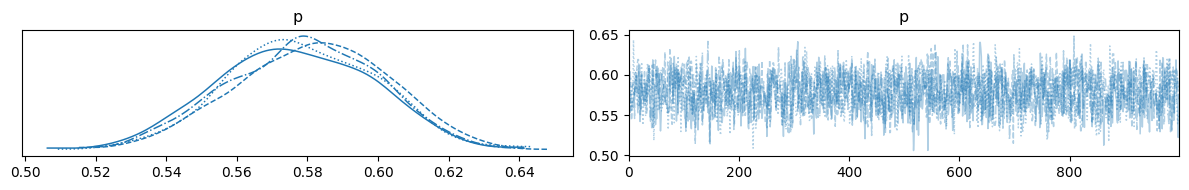

[0.54182492 0.61234654]


In [1124]:
with pm.Model() as model_bernoulli:
    p = pm.Beta("p", alpha=2, beta=2)  
    
    likelihood = pm.Bernoulli("observed_data", p=p, observed=Y)
    
    trace = pm.sample(1000, tune=1000)

print(pm.summary(trace))

plt.figure(figsize=(8, 5))
pm.plot_trace(trace)
plt.tight_layout()
plt.show()

ps = trace.posterior.p.values.flatten()
hdis = az.hdi(ps , hdi_prob = .9)
print(hdis)


Este modelo se acerca mas a lo que busco, pero todavia no incorpora $condition$ y $pulled$ $left$ en el modelo. Por esto, propongo un modelo donde la likelihood es una bernoulli y p se modela como una regresion logistica, lo que me permite incorporar a las variables predictoras. Los betas estan modelados con una distribucion normal, con valores de mu y sigma no informativos.

In [1125]:
X1 = data['prosoc_left']
X2 = data['condition']

Y = data['pulled_left']

with pm.Model() as model:
    #elijo priors no informativos
    b0 = pm.Normal("b0", mu=0, sigma=10)      
    b1 = pm.Normal("b1", mu=0, sigma=10)   
    b2 = pm.Normal("b2", mu=0, sigma=10) 

    # defino eta
    eta = b0 + b1 * X1 + b2 * X2

    #regresion logistica -> defino p 
    p = pm.math.exp(eta)  / (1 + pm.math.exp(eta)) 

    #defino la likelihood
    likelihood = pm.Bernoulli("pulled_left", p=p, observed=Y)
        
    trace = pm.sample(1000, tune=1000, return_inferencedata=True)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b0, b1, b2]


C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-package
s\Python311\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 375 seconds.


In [1126]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b0,0.144,0.157,-0.132,0.452,0.004,0.003,1934.0,2160.0,1.0
b1,0.569,0.182,0.232,0.918,0.004,0.003,1991.0,1959.0,1.0
b2,-0.198,0.188,-0.578,0.127,0.004,0.003,2057.0,2111.0,1.0


<Figure size 800x500 with 0 Axes>

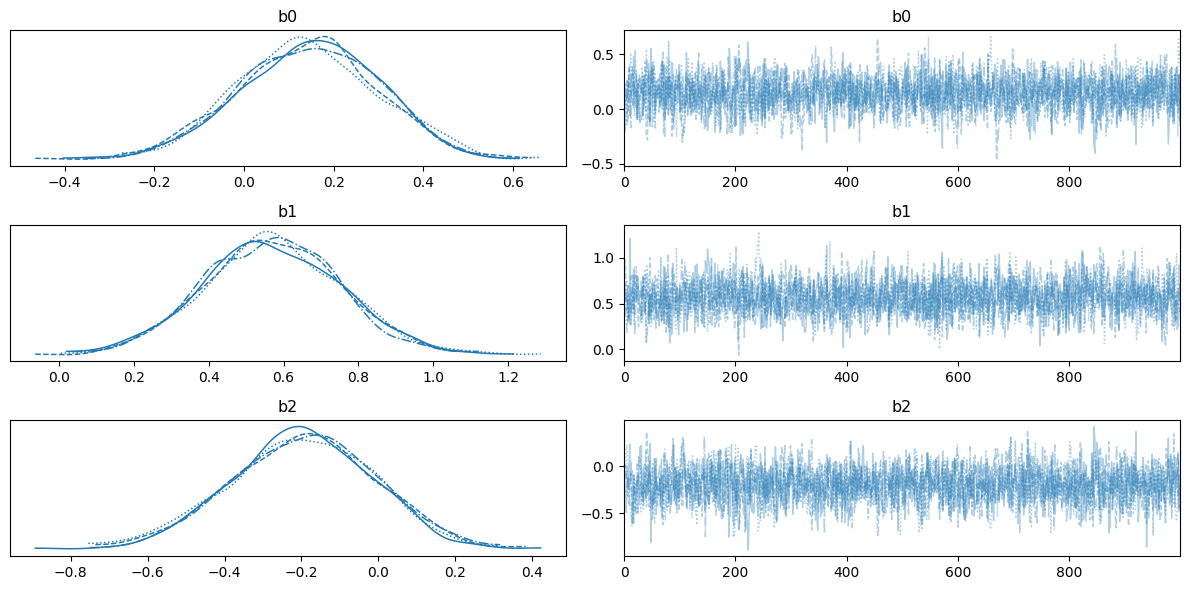

In [1127]:
#grafico la posterior de cada parametro estimado
plt.figure(figsize=(8, 5))
pm.plot_trace(trace)
plt.tight_layout()
plt.show()

In [1128]:
#Obtengo el intervalo de credibilidad al 95% (HDI) para cada parámetro:

b0_samples = trace.posterior['b0'].values.flatten()
b1_samples = trace.posterior['b1'].values.flatten()
b2_samples = trace.posterior['b2'].values.flatten()

print(f'95% HDI para b0: {az.hdi(b0_samples, hdi_prob=0.95)}')
print(f'95% HDI para b1: {az.hdi(b1_samples, hdi_prob=0.95)}')
print(f'95% HDI para b2: {az.hdi(b2_samples, hdi_prob=0.95)}')

95% HDI para b0: [-0.15433248  0.45156835]
95% HDI para b1: [0.20933475 0.92109555]
95% HDI para b2: [-0.58998356  0.14146319]


In [1129]:
eta_pred1 = b0_samples + 0 * b1_samples + 0 * b2_samples  
eta_pred2 = b0_samples + 0 * b1_samples + 1 * b2_samples  
eta_pred3 = b0_samples + 1 * b1_samples + 0 * b2_samples  
eta_pred4 = b0_samples + 1 * b1_samples + 1 * b2_samples  

p_pred1 = np.exp(eta_pred1) / (1 + np.exp(eta_pred1))  
p_pred2 = np.exp(eta_pred2) / (1 + np.exp(eta_pred2))  
p_pred3 = np.exp(eta_pred3) / (1 + np.exp(eta_pred3))  
p_pred4 = np.exp(eta_pred4) / (1 + np.exp(eta_pred4))  


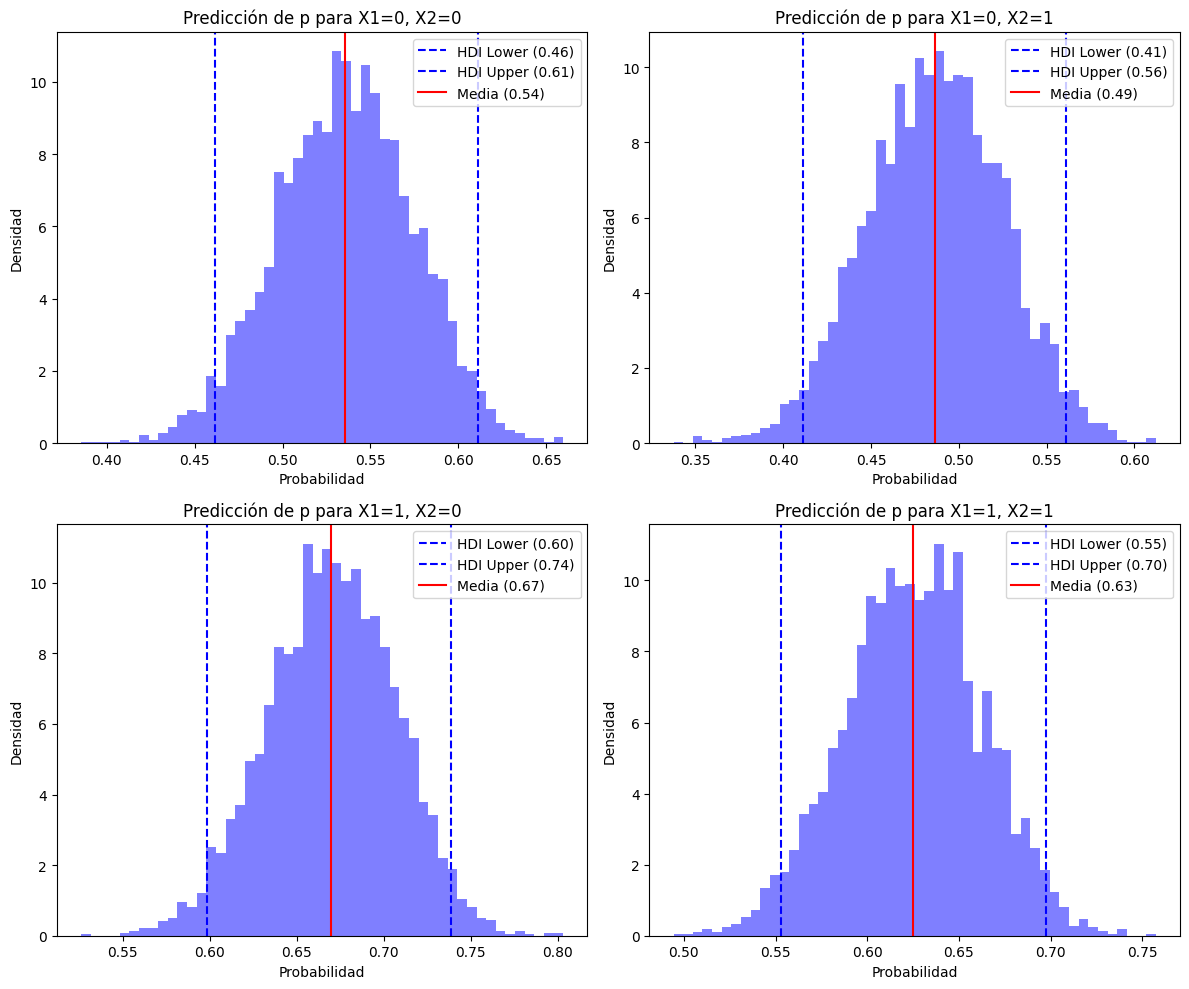

In [1130]:
predictions = [
    (p_pred1, "X1=0, X2=0"),
    (p_pred2, "X1=0, X2=1"),
    (p_pred3, "X1=1, X2=0"),
    (p_pred4, "X1=1, X2=1"),
]

plt.figure(figsize=(12, 10))

for i, (pred, label) in enumerate(predictions, start=1):
    HDI_pred = az.hdi(pred, hdi_prob=0.95)
    mean_pred = np.mean(pred)

    plt.subplot(2, 2, i)
    plt.hist(pred, bins=50, density=True, color='blue', alpha=0.5)
    plt.axvline(HDI_pred[0], color='blue', linestyle='--', label=f"HDI Lower ({HDI_pred[0]:.2f})")
    plt.axvline(HDI_pred[1], color='blue', linestyle='--', label=f"HDI Upper ({HDI_pred[1]:.2f})")
    plt.axvline(mean_pred, color='red', linestyle='-', label=f"Media ({mean_pred:.2f})")
    plt.title(f"Predicción de p para {label}")
    plt.xlabel("Probabilidad")
    plt.ylabel("Densidad")
    plt.legend()

plt.tight_layout()
plt.show()

Interpeto estos resultados, como que cuando X1 = 1, o sea la opcion prosocial esta del lado izquierdo, puedo asegurar con un 95% de probabilidades que la probabilidad de que tire de la palanca izquierda es mayor a 0.5. O sea que es mas probable que tire de la izquierda.

Mientras tanto, en los otros casos no puedo hacerlo, con tanta seguridad. Si bien la esperanza (la media) cae de un lado del 0.5, este es parte del intervalo de confianza, por lo que no se puede asegurar con tanta certeza de que lado cae p

De la misma manera que con el metodo frecuentista, si en lugar de predecir la probabilidad de que tire de la palanca izquiera, y quisiera saber la probabilidad de que elija la opcion prosocial, puedo usar la columna $chose$ $prosoc$ como target

In [1131]:
X1 = data['prosoc_left']
X2 = data['condition']

Y = data['chose_prosoc']

with pm.Model() as model:
    b0 = pm.Normal("b0", mu=0, sigma=10)      
    b1 = pm.Normal("b1", mu=0, sigma=10)   
    b2 = pm.Normal("b2", mu=0, sigma=10) 

    eta = b0 + b1 * X1 + b2 * X2
    p = pm.math.exp(eta)  / (1 + pm.math.exp(eta)) 

    likelihood = pm.Bernoulli("chose_prosoc", p=p, observed=Y)
        
    trace = pm.sample(1000, tune=1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b0, b1, b2]


C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-package
s\Python311\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 355 seconds.


In [1132]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b0,-0.094,0.149,-0.358,0.201,0.003,0.002,2150.0,2494.0,1.0
b1,0.656,0.184,0.323,0.998,0.004,0.003,2492.0,2739.0,1.0
b2,0.095,0.178,-0.225,0.445,0.004,0.003,2251.0,2403.0,1.0


<Figure size 800x500 with 0 Axes>

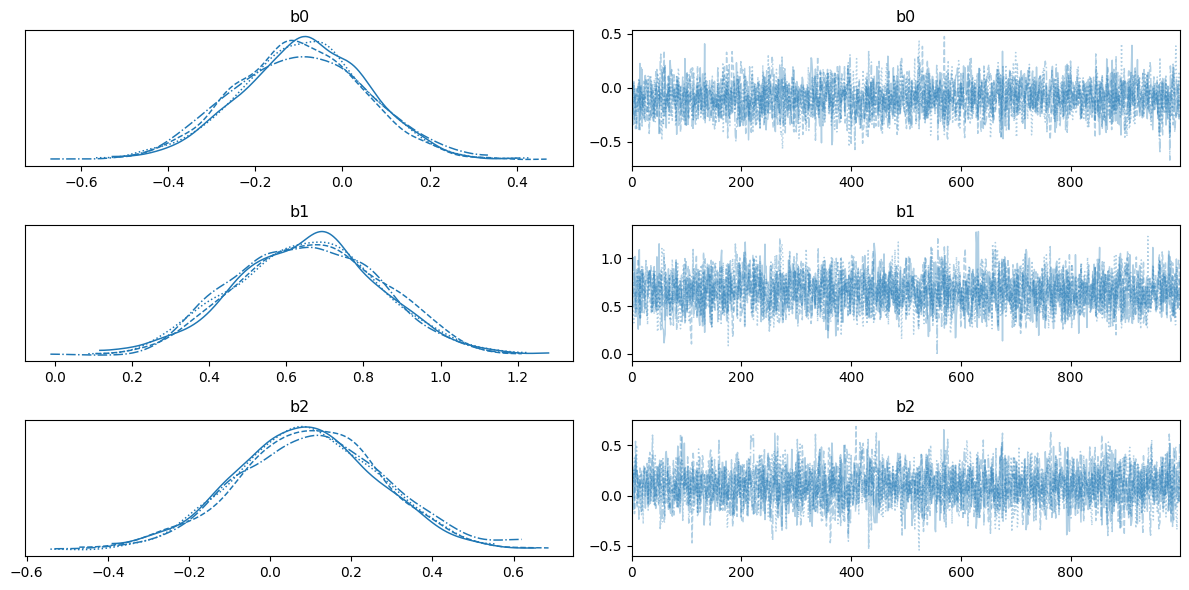

In [1133]:
plt.figure(figsize=(8, 5))
pm.plot_trace(trace)
plt.tight_layout()
plt.show()

In [1134]:
b0_samples = trace.posterior['b0'].values.flatten()
b1_samples = trace.posterior['b1'].values.flatten()
b2_samples = trace.posterior['b2'].values.flatten()

print(f'95% HDI para b0: {az.hdi(b0_samples, hdi_prob=0.95)}')
print(f'95% HDI para b1: {az.hdi(b1_samples, hdi_prob=0.95)}')
print(f'95% HDI para b2: {az.hdi(b2_samples, hdi_prob=0.95)}')

95% HDI para b0: [-0.38157395  0.19825762]
95% HDI para b1: [0.31717381 1.02001288]
95% HDI para b2: [-0.26464277  0.43219509]


In [1135]:
eta_pred1 = b0_samples + 0 * b1_samples + 0 * b2_samples  
eta_pred2 = b0_samples + 0 * b1_samples + 1 * b2_samples  
eta_pred3 = b0_samples + 1 * b1_samples + 0 * b2_samples  
eta_pred4 = b0_samples + 1 * b1_samples + 1 * b2_samples  

p_pred1 = np.exp(eta_pred1) / (1 + np.exp(eta_pred1))  
p_pred2 = np.exp(eta_pred2) / (1 + np.exp(eta_pred2))  
p_pred3 = np.exp(eta_pred3) / (1 + np.exp(eta_pred3))  
p_pred4 = np.exp(eta_pred4) / (1 + np.exp(eta_pred4))  

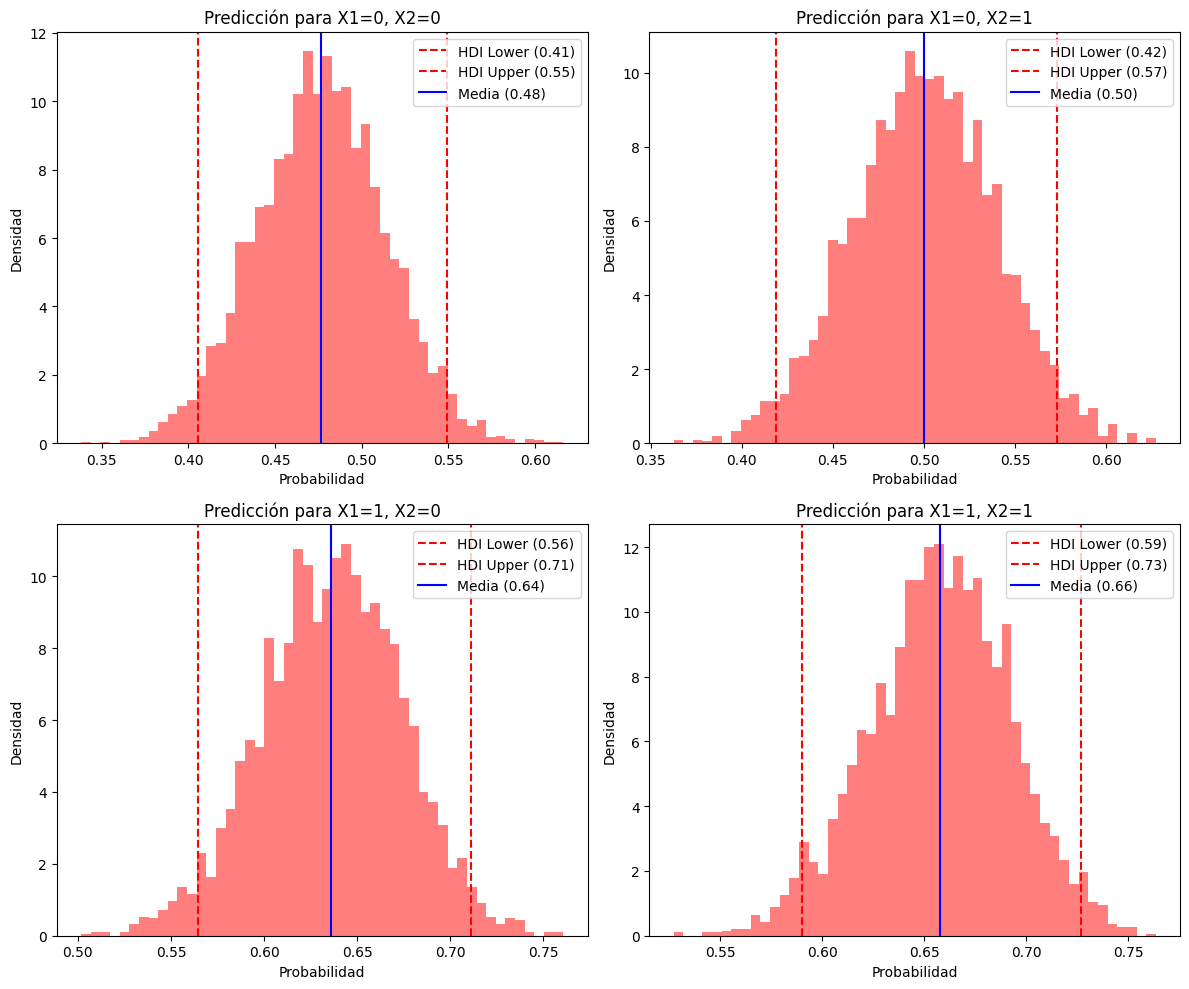

In [1136]:
predictions = [
    (p_pred1, "X1=0, X2=0"),
    (p_pred2, "X1=0, X2=1"),
    (p_pred3, "X1=1, X2=0"),
    (p_pred4, "X1=1, X2=1"),
]

plt.figure(figsize=(12, 10))

for i, (pred, label) in enumerate(predictions, start=1):
    HDI_pred = az.hdi(pred, hdi_prob=0.95)
    mean_pred = np.mean(pred)

    plt.subplot(2, 2, i)
    plt.hist(pred, bins=50, density=True, color='red', alpha=0.5)  
    plt.axvline(HDI_pred[0], color='red', linestyle='--', label=f"HDI Lower ({HDI_pred[0]:.2f})") 
    plt.axvline(HDI_pred[1], color='red', linestyle='--', label=f"HDI Upper ({HDI_pred[1]:.2f})")  
    plt.axvline(mean_pred, color='blue', linestyle='-', label=f"Media ({mean_pred:.2f})")
    plt.title(f"Predicción para {label}")
    plt.xlabel("Probabilidad")
    plt.ylabel("Densidad")
    plt.legend()

plt.tight_layout()
plt.show()


En este caso puedo hacer una interpretacion similar, cuando X1= 1, o sea, la opcion prosocial esta a la izquierda, puedo asumir con un 95% de seguiridad que la probabilidad de que elija la opcion prosocial es mayor a 0.5, mientras que si la opcion prosocial esta a la derecha, no puedo estar segura, ya que el intervalo de confianza contiene al 0.5